## Primer: iskanje neslanih šal

<br/>
Tokrat si bomo ogledali zbirko podatkov Jester, ki je dokaj podobna tisti pri domači nalogi. Gre za zbirko 100 šal (vicev), ki jih je ocenilo 23500 uporabnikov z oceno $-10$ (porazno) do $10$ (odlično). 
Ocena je torej zvezna spremenljivka. 

Naš glavni cilj bo modeliranje statistik v podatkovni zbirki z uporabo znanih porazdelitev. To nam bo omogočalo da  <b>med šalami poiščemo osamelce</b> in ocenimo njihovo statistično značilnost - verjetnost, da gre za osamelca ali ne. 







Začnimo z naključno šalo iz podatkovne zbirke: <code>A mechanical, electrical and a software engineer from Microsoft were driving through the desert when the car broke down. The mechanical engineer said "It seems to be a problem with the fuel injection system, why don't we pop the hood and I'll take a look at it." To which the electrical engineer replied, "No I think it's just a loose ground wire, I'll get out and take a look." Then, the Microsoft engineer jumps in. "No, no, no. If we just close up all the windows, get out, wait a few minutes, get back in, and then reopen the windows everything will work fine."</code> 





In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

Podatki so matrika velikosti $23500 \times 100$ z zveznimi vrednosti. Vrednost $99$ predstavlja neznano vrednost, takih vrednosti zato ne smemo upoštevati.

In [2]:
X = np.genfromtxt('podatki/jester-data.csv', delimiter='',)[:, 1:]
X[np.where(X == 99)] = float("nan")  # neznanih vrednosti ne smemo upoštevati

print("Velikost:", X.shape)
print("Skupno število ocen:", X.size - np.sum(np.isnan(X)))

IndexError: too many indices for array

Poglejmo, kakšna je porazdelitev vseh veljavnih ocen.

In [3]:
# Porazdelitev vseh ocen
data = X[np.isnan(X) == False]
plt.hist(data, bins=100)
plt.xlabel("x - Ocena šale")
plt.ylabel("P(x)")
plt.show()

NameError: name 'X' is not defined

 Vidimo, da je večina ocen nevtralnih (okoli 0), veliko pozitivnih (med 3 in 10) ter nekaj zelo slabih (-10). Najmanj je srednje slabih (-9 do -1). Navkljub temu ima ta porazdelitev naslednje težave:
 * Vzorec ni nepristranski. Vsak uporabnik je ocenil različno število šal.
 * Porazdelitev ne spominja na nobeno od znanih.
 
Kako bi primerjali šale glede na njihove ocene? Vsaka šala je dobila nekaj tisoč ocen, kar zadostuje za statistično primerjavo.
 

In [4]:
(np.isnan(X) == False).sum(axis=0)  # število ocen za vsako od 100 šal

NameError: name 'X' is not defined

Zamislimo si dve novi naključni spremenljivki:
    
* $X$ Povprečje ocen posamezne šale.
* $Y$ Varianca ocen posamezne šale.

<br/>

<font color="red"><b>Pomembno: spremenljivki sta izpeljani iz dveh izračunljivih količih. Spremenljivk $X$ in $Y$ ne smemo pomešati s parametri normalne porazdelitve! </b></font>

Za vsako od navedenih spremljivk $X$ in $Y$ imamo torej vzorec velikosti 100, po en primer za vsako šalo. Pri izračunu pazimo, da preskočimo neznane vrednosti.

In [5]:
# Porazdelitev povprečij ocen
means     = []
variances = []
for i in range(X.shape[1]):
    s = np.mean(X[:, i][np.isnan(X[:, i]) == False])
    v = np.var(X[:, i][np.isnan(X[:, i]) == False])
    means.append(s)
    variances.append(v)

NameError: name 'X' is not defined

<font color="blue"><b>Razmisli.</b></font> Kakšna je interpretacija spremeljivk $X$ in $Y$? Kaj pomeni, če ima šala visoko varianco med vsemi ocenami? Kaj pomeni, če ima šala visoko povprečno oceno?

Izpišimo nekaj najbolje, najslabše ocenjenih šal ter nekaj takih z visoko oz. nizko varianco. Za zabavo jih lahko prebereš in primerjaš (pot ```jokes/init1.html```).

In [6]:
n = 5
for data, name in [(means, "Povprečja (X)"), (variances, "Variance (Y)")]: 
    inxs = np.argsort(data)[:5]
    print("Kriterij: %s" % name)
    print("\tSpodnjih %d:" % n)
    for i in inxs:
        print("\t\tJoke index: %d, mean: %.5f, variance: %.5f" % (i+1, means[i], variances[i]))
        
    inxs = np.argsort(data)[::-1][:5]
    print("\tZgornjih %d:" % n)
    for i in inxs:
        print("\t\tJoke index: %d, mean: %.5f, variance: %.5f" % (i+1, means[i], variances[i]))
    print()

Kriterij: Povprečja (X)
	Spodnjih 5:
	Zgornjih 5:

Kriterij: Variance (Y)
	Spodnjih 5:
	Zgornjih 5:



Narišimo še porazdelitvi vzorcev $X$ in $Y$.

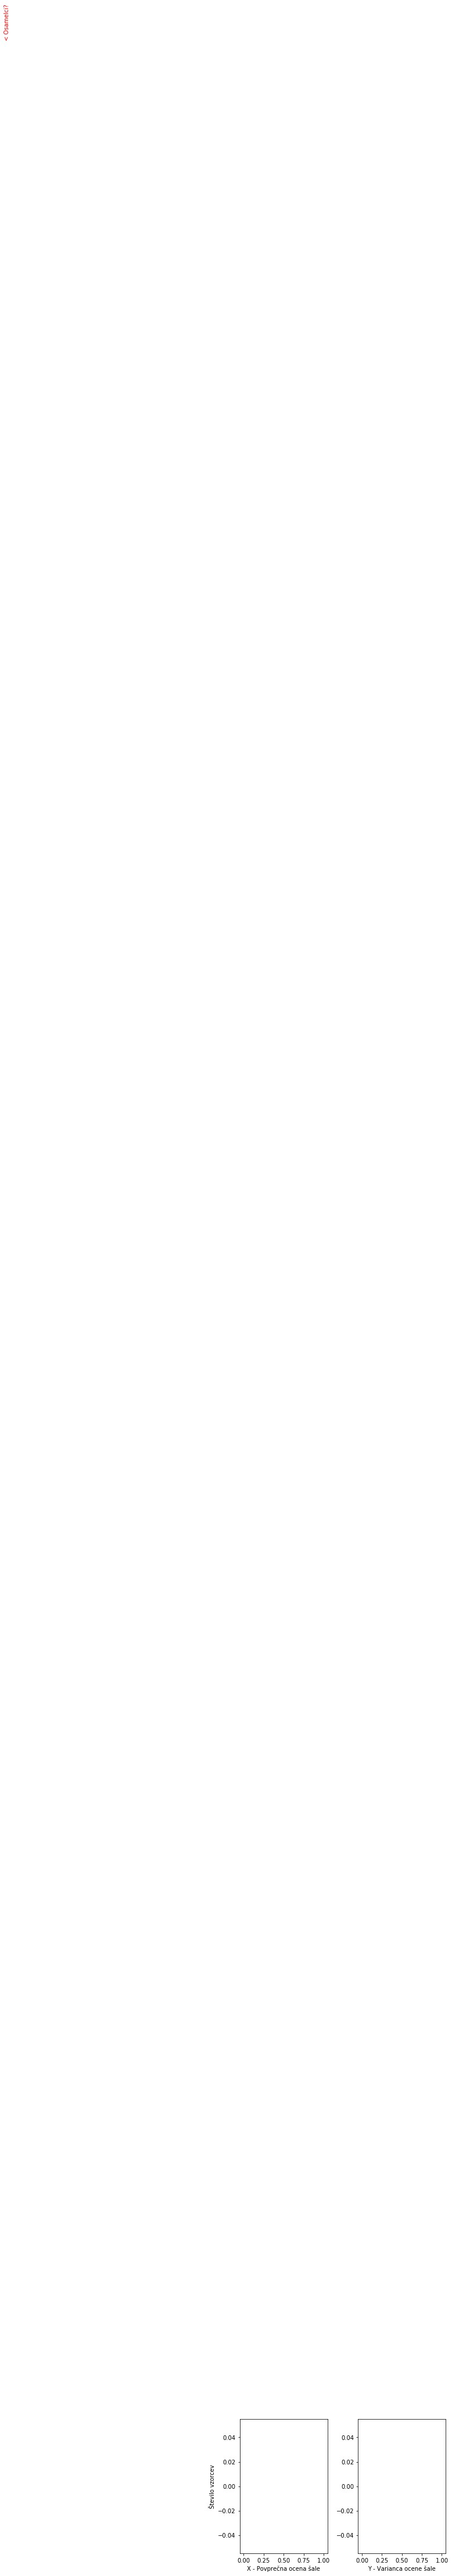

In [7]:
plt.subplot(1, 2, 1)
plt.hist(means, normed=False, bins=12)
plt.xlabel("X - Povprečna ocena šale")
plt.ylabel("Število vzorcev")
plt.text(-3, 2, "< Osamelci?", rotation=90, verticalalignment="bottom", color="red")

plt.subplot(1, 2, 2)
plt.hist(variances, normed=False, bins=12)
plt.xlabel("Y - Varianca ocene šale")


plt.tight_layout()
plt.show()

Tole izgleda že bolje. Večina šal je torej v povprečju ocenjenih pozitivno, zelo malo je negativnih. 
Porazdelitvi spominjata na znane porazdelitve, kjer je večina primerov (šal) porazdeljenih okoli srednje vrednosti, manj pa je ekstremnih vrednosti.


Poglejmo za trenutek porazdelitev povprečnih ocen. Izgleda, da imamo nekaj <font color="red"><b>osamelcev</b></font> - zelo slabih šal, ocenjenih od $X = -2$ navzdol. Kako pomenljiv je padec od $X = -2$ navzdol? Da bi odgovorili na to vprašanje, spoznajmo osnove modeliranja podatkov s pomočjo verjetnostnih porazdelitev.

Povprečna ocena izgleda normalno porazdeljena. Kakšni so najbolj verjetni parametri porazdelitve? 

In [8]:
from scipy.stats import multivariate_normal as mvn

data = means
    
# Ocenimo parametre normalne (Gaussove) porazdelitve
n = len(data)
mu = np.mean(data)              # ocena sredine
sigma2 = (n-1)/n * np.var(data) # ocena variance

plt.figure()
counts, bins, _ = plt.hist(data, normed=True, label="Vzorec", bins=10)    # dobimo razpon
pdf = [mvn.pdf(x, mu, sigma2) for x in bins]                              # pdf: [p]robability [d]ensity [f]unction
plt.plot(bins, pdf, "-", label="Model", linewidth=2.0)
plt.xlabel("X - povprečna ocena")
plt.ylabel("P(X)")

plt.legend(loc=2)
plt.show()

/Users/tomazc/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tomazc/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: division by zero

Na oko lahko ocenimo, da se porazdelitev kar dobro ujema z vzorcem. Kako statistično značilne so šale, ki imajo vrednost meritve manjšo od $X=-2.0$? <i>Kako nenavadno slabe so v resnici te šale?</i>

Za odgovor na to vprašanje bomo izračunali t.i. <i>p-vrednost</i>. S pomočjo p-vrednosti ocenimo <i>nenavadnost</i> meritve, v našem primeru povprečne ocene šale.

<br/>
<br/>

<b>Definicija.</b> P-vrednost je verjetnost, da pri vzorčenju ene vrednosti naključne spremenljivke dobimo dano ali manjšo (oz. večjo) vrednost. 


Definicijo si najlažje ogledamo grafično. Oglejmo si funkcijo porazdelitve, dobljeno z ocenjenima parametroma $\mu$ in $\sigma^2$.


In [9]:
# Meritev, ki bi jo radi statisticno ocenili  
qx = 0                  


# Izračunamo P(x) za dovolj velik interval
xr    = np.linspace(-5, 5, 100)
width = xr[1] - xr[0]       # sirina intervala
Px = [mvn.pdf(x, mu, sigma2) * (xr[1]-xr[0])   for x in xr]


# Vse vrednosti, ki so manjše ali enake od qx
ltx     = xr[xr <= qx]      

# Množimo s širino intervala, da dobimo ploščino pod krivuljo
P_ltx = [mvn.pdf(x, mu, sigma2) * width for x in ltx] 
                            
# p-vrednost: ploscina pod krivuljo P(x) za vse vrednosti, manjse od qx
p_value = np.sum(P_ltx )

# Graf funkcije
plt.figure()
plt.plot(xr, Px, linewidth=2.0,)
plt.fill_between(ltx, 0, P_ltx, alpha=0.2,)
plt.text(qx, mvn.pdf(qx, mu, sigma2) * width, 
         "p=%f" % p_value,  
         horizontalalignment="right",
         verticalalignment="center",)

plt.xlabel("X - povprečna ocena šale.")
plt.ylabel("P(X)")
plt.legend()
plt.show()


# Poglejmo, ali je meritev statistično značilna pri danem pragu alpha (0.05, 0.01, 0.001 ... )
alpha = 0.05
if p_value < alpha:
        sig = "JE"
else:
        sig = "NI"

# Rezultat statističnega testa
print("Verjetnost šale z oceno %.3f ali manj (statistična značilnost): " % qx + "%.3f" % (100 * p_value) +  " %")
print("Nenavadnost šale %s statistično značilna (prag = %.3f" % (sig, 100*alpha), "%)")

NameError: name 'sigma2' is not defined

Sedaj lahko za vsako ekstremno vrednost v podatkih (bodisi visoko ali nizko) <i>statistično</i> ocenimo vrednost njene nenavadnosti. Pri postavljenem pragu npr. $\alpha = 0.05$ lahko sprejmemo odličitev, ali je neka meritev osamelec ali ne.

<font color="green"><b>Naredi sam/a</b></font>. Izpiši vse šale osamelce, katerih povprečna ocena $X$ je statistično značilna, pri pragu $\alpha=0.05$. Poišči tudi osamelce med <i>dobro ocenjenimi</i> šalami.

<font color="green"><b>Naredi sam/a</b></font>. Poizkusi porazdelitev modelirati z drugimi porazdelitvami (Student, Beta). Je katera od teh porazdelitev bolj primerna?

<font color="green"><b>Naredi sam/a</b></font>. Ponovi analizo za spremenljivko $Y$ - varianca ocen šale. Odgovori na vprašanja:
* Katera od porazdelitev (normalna, Student, Beta) se najbolje prilega vzorcu?
* Katere so statistično značilne šale (z visoko ali nizko varianco)?
* Kaj pomeni, če ima šala visoko ali nizko vrednost $Y$?